In [ ]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv(
	'https://raw.githubusercontent.com/numenta'
	'/NAB/master/data/realKnownCause/ambient'
	'_temperature_system_failure.csv')

# Exclude datetime column
data_values = data.drop('timestamp',
						axis=1).values

# Convert data to float type
data_values = data_values.astype('float32')

# Create new dataframe with converted values
data_converted = pd.DataFrame(data_values,
							columns=data.columns[1:])

# Add back datetime column
data_converted.insert(0, 'timestamp',
					data['timestamp'])

In [ ]:
data_converted = data_converted.dropna()

In [ ]:
# Exclude datetime column again
data_tensor = tf.convert_to_tensor(data_converted.drop(
	'timestamp', axis=1).values, dtype=tf.float32)

# Define the autoencoder model
input_dim = data_converted.shape[1] - 1
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=50,
				batch_size=32, shuffle=True)

# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tf.reduce_mean(tf.square(data_tensor - reconstructions),
					axis=1)
anomaly_scores = pd.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

Epoch 1/50
228/228 [==============================] - 1s 2ms/step - loss: 180.4648
Epoch 2/50
228/228 [==============================] - 1s 4ms/step - loss: 4.9367e-04
Epoch 3/50
228/228 [==============================] - 1s 4ms/step - loss: 4.9102e-04
Epoch 4/50
228/228 [==============================] - 1s 3ms/step - loss: 4.9030e-04
Epoch 5/50
228/228 [==============================] - 0s 2ms/step - loss: 4.9004e-04
Epoch 6/50
228/228 [==============================] - 0s 2ms/step - loss: 4.8927e-04
Epoch 7/50
228/228 [==============================] - 0s 1ms/step - loss: 4.8802e-04
Epoch 8/50
228/228 [==============================] - 0s 2ms/step - loss: 4.8755e-04
Epoch 9/50
228/228 [==============================] - 0s 1ms/step - loss: 4.8648e-04
Epoch 10/50
228/228 [==============================] - 0s 2ms/step - loss: 4.8526e-04
Epoch 11/50
228/228 [==============================] - 0s 2ms/step - loss: 4.8460e-04
Epoch 12/50
228/228 [==============================] - 0s 2ms/ste

In [ ]:
threshold = anomaly_scores.quantile(0.99)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,f1_score, _ = precision_recall_fscore_support(
		binary_labels, anomalous, average='binary')

In [ ]:
test = data_converted['value'].values
predictions = anomaly_scores.values

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  1.0
Recall:  1.0
F1 Score:  1.0


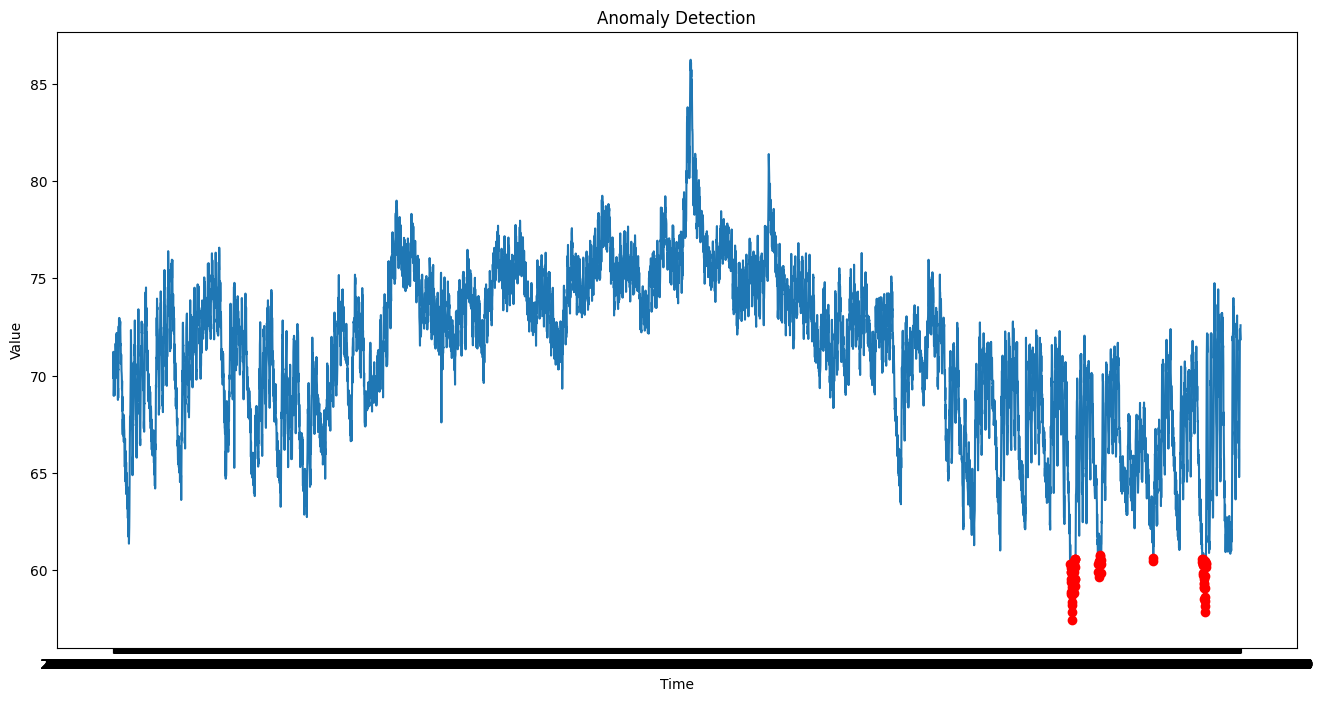

In [ ]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(data_converted['timestamp'],
		data_converted['value'])
plt.plot(data_converted['timestamp'][anomalous],
		data_converted['value'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
